# MAP推定

最大事後確率（*Maximum a posteriori*）推定。あるデータ$X$が得られた時、事後分布が最も高い値をとるパラメータ$\theta$を推定する。

$$
\hat\theta = \argmax_{\theta} p(\theta|X)
$$

In [1]:
import torch
import pyro.distributions as dist
import matplotlib.pyplot as plt

まず、MAP推定を学ぶ上で必要な概念を理解する。


---

## ベイズの定理

条件付き確率に関する以下の公式。

$$
p(A|B) = \frac{p(B|A)p(A)}{p(B)}
$$

A,Bは何らかの事象。Aが原因でBを結果だとすると、原因Aの元で結果Bが起きる確率$p(B|A)$という求めやすい値から、その逆の確率$P(A|B)$を求められる。$p(A)$は事前確率、$p(A|B)$は事後確率と呼ぶ。

<br>

よくある例題
- [病気に罹患している確率は？　ベイズの定理で求める方法を解説／『Pythonで動かして学ぶ！』シリーズ|CodeZine（コードジン）](https://codezine.jp/article/detail/14581)


---

## 事後分布

データ$X$とパラメータ$\theta$でもベイズの定理を適用することができる。

$$
p(\theta|X) = \frac{p(X|\theta)p(\theta)}{p(X)}
$$

- $p(\theta|X)$: 事後分布。データ$X$が得られた時、そのデータがパラメータ$\theta$（に従う分布）から生成された確率。
- $p(X|\theta)$: 尤度。パラメータ$\theta$の下でデータ$X$が得られる確率。
- $p(\theta)$: 事前分布。パラメータ$\theta$が得られる確率。
- $p(X)$: 周辺尤度: $p(X)=\int p(X|\theta)p(\theta) d\theta$。データ$X$が得られる確率。

<br>

MAP推定を行う際は、↑のようにベイズの定理を用いて式を変換する。

$$
\begin{align}
\argmax_{\theta} p(\theta|X) &= \argmax_{\theta} \frac{p(X|\theta)p(\theta)}{p(X)} \\
&= \argmax_{\theta} p(X|\theta)p(\theta) \\
\end{align}
$$

最尤推定で求めたものは以下であった。

$$
\argmax_{\theta} p(X|\theta)
$$

MAP推定では、**パラメータ$\theta$も確率変数とみなし**、$X$の尤度$p(X|\theta)$だけでなくそのパラメータ$\theta$の尤度$p(\theta)$も考慮して$\theta$を推定する。  
事後分布は、$X$の尤度を$\theta$の尤度で重み付けしたものというイメージ。

また事前分布$p(\theta)$には**主観的**な知見を反映させる。


---

## 総当たりでの推定

では実際にMAP推定を行ってみる。  
$\theta$の値を全て試して、事後確率が最大になる$\theta$を求める。

例題

> 東京都に住む成人男性の平均身長（cm）を求めたい。アンケートを実施して、10000の標本を集めることができた。この10000人分のデータを元に、平均身長を求める。具体的には、身長が正規分布に従うと仮定し、その分布の平均値を求める。なお標準偏差は既知で$\sigma=10$とする。また、日本の成人男性の身長が平均170、標準偏差10の正規分布に従うことを知っているとする。

日本人の身長のデータは分かっているけど、東京都の身長のデータは分からない、という状態。

<br>

以下のような標本が得られたとしよう。

bar_x: tensor(174.1185)


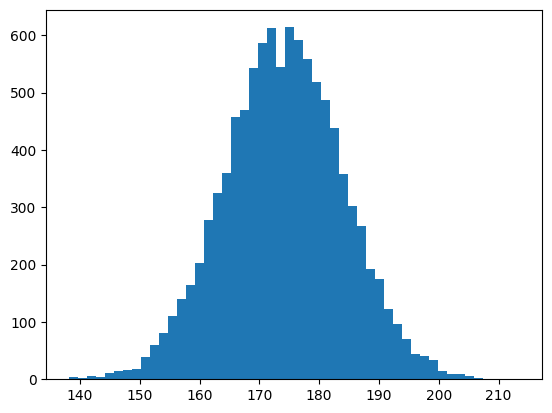

In [2]:
norm = dist.Normal(174, 10)
x = norm.sample((10000,))
print('bar_x:', x.mean())
plt.hist(x, bins=50);

この標本は平均174、標準偏差10の正規分布から得られている。つまり174が答え。ただこれを知らないものとして、推定する。

では実際に総当たりで求めていく。ただ今回は確率変数$x$（身長）が連続値で範囲が正の実数なので、適当に範囲と分解能を決めて離散化する。

In [3]:
theta = torch.arange(160, 180, 0.1) # 160~180までを0.1刻みで

次に事前分布を決める。今回は、日本の成人男性の身長の分布を知っているという設定がある。そしてそれはパラメータ$\theta$の事前分布として適しているだろうと考えられる。これが主観的な知見に当たる。

ということで、事前分布は日本の成人男性の身長の分布（平均170、標準偏差10の正規分布）$\mathcal N(170, 10)$とする。

In [4]:
prior = dist.Normal(170, 10)

あとは計算をするだけ。

$$
\begin{align}
\argmax_{\theta} p(\theta|X) &= \argmax_{\theta} \frac{p(X|\theta)p(\theta)}{p(X)} \\
&= \argmax_{\theta} p(X|\theta)p(\theta) \\
\end{align}
$$

より、各$\theta$で以下を求め、最も大きくなった$\theta$を見つける。

$$
p(X|\theta)p(\theta)
$$

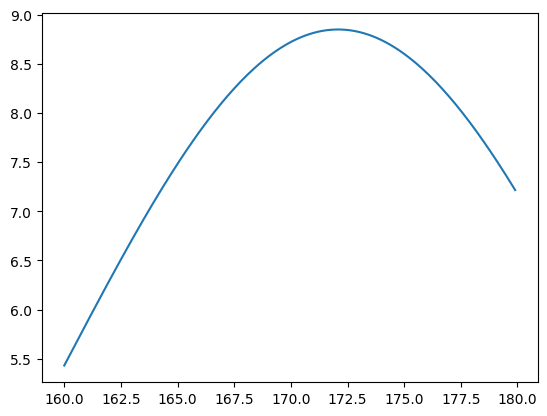

In [5]:
y = []
for t in theta:
    likelihood = dist.Normal(t, 10).log_prob(x).exp()
    prior_prob = prior.log_prob(x).exp()
    y_ = likelihood * prior_prob
    y.append(y_.sum().item())
plt.plot(theta, y);

In [6]:
print("MAP推定値:", theta[torch.argmax(torch.tensor(y))].item())

MAP推定値: 172.10000610351562



---

## 解析的な推定

総当たりは精度や計算コストの面で問題があるので、解析的に求める。やり方は最尤推定と同じで、対数をとって微分する。

ではやっていこう。さっきの例題を使う。  
求めるものは以下。

$$
\argmax_{\theta} \, \log(p(\theta|X)) = \argmax_{\theta} \, \log(p(X|\theta)p(\theta))
$$

式変形。

$$
\begin{align}
\log(p(X|\theta)p(\theta))
    &= \log(\prod_{i=1}^n p(x_i|\theta) \, p(\theta)) \\
    &= \sum_{i=1}^n \log p(x_i|\theta) + \log p(\theta)
\end{align}
$$

ここで、定義した事前分布と事後分布

$$
\begin{align}
p(x_i|\theta) &= \mathcal N(x_i; \theta, 10) \\
p(\theta) &= \mathcal N(\theta; 170, 10) \\
\end{align}
$$

により、以下が成り立つ

$$
\begin{align}
\log p(x_i|\theta)
    &= \log \left( \frac{1}{\sqrt {200\pi}} \exp \left( -\frac{(x_i-\theta)^2}{200} \right) \right) \\
    &= \log \left( \frac{1}{\sqrt {200\pi}} \right)  - \frac{(x_i-\theta)^2}{200} \\ \\

\log p(\theta)
    &= \log \left( \frac{1}{\sqrt {200\pi}} \exp \left( -\frac{(\theta-170)^2}{200} \right) \right) \\
    &= \log \left( \frac{1}{\sqrt {200\pi}} \right)  - \frac{(\theta-170)^2}{200} \\ \\
\\
\log (p(X|\theta)p(\theta))
    &= \sum_{i=1}^n \left( \log \left( \frac{1}{\sqrt {200\pi}} \right)  - \frac{(x_i-\theta)^2}{200} \right) + \log \left( \frac{1}{\sqrt {200\pi}} \right)  - \frac{(\theta-170)^2}{200} \\
    &= -\frac{1}{200} \left( \sum_{i=1}^n (x_i-\theta)^2 + (\theta-170)^2 \right) + \text{const} \\
\end{align}
$$

$\theta$に関係のない定数項は$\mathrm{const}$とした。

事後分布を明確に表したので、これを微分する。

$$
\begin{align}
\frac{\partial}{\partial\theta} \log p(X|\theta)p(\theta)
    &= -\frac{1}{200} \left( \sum_{i=1}^n\frac{\partial}{\partial\theta}(x_i-\theta)^2 + \frac{\partial}{\partial\theta}(\theta-170)^2 \right) \\
    &= -\frac{1}{200} \left( -2\sum_{i=1}^n (x_i-\theta) + 2(\theta-170) \right) \\
    &= \frac{1}{100} \left( \sum_{i=1}^n (x_i-\theta) - (\theta-170) \right) \\
    &= \frac{1}{100} (n\bar X - (n+1)\theta + 170) \\
\end{align}
$$

最後は$X$の平均$\bar X=\frac{\sum x}{n}$を使った変形。

でこれが0になる$\theta$を求める。

$$
\begin{align}
    -\frac{1}{100} (n\bar X - (n+1)\theta + 170) &= 0 \\
    n\bar X - (n+1)\theta + 170 &= 0 \\
    \frac{n\bar X + 170}{n+1} &= \theta \\
\end{align}
$$

できた。  
ここに$n=10000$、$\bar X=174$を代入すると具体的な値が得られる。

In [7]:
n, bar_x = 10000, 174
map_est = (n*bar_x + 170) / (n + 1)
print("MAP推定値:", map_est)

MAP推定値: 173.999600039996


サンプル数$n$が大きくなればなるほど$\theta$が標本平均$\bar X$に近づく。これは直感的にも納得がいくと思う。サンプル数が多ければその標本を信じるようにして、少なければ事前分布に頼るといったイメージ。  
実際に↑で代入した結果標本平均174とほとんど同じ値になっているね。